#### Octavio Revetria 232745

# Derivadas con PyTorch

**Objetivo.** Usar `torch.autograd` como motor de derivadas para verificar definiciones, propiedades básicas (linealidad, producto, cadena), gradientes, y Jacobianos, con ejercicios guiados y comprobaciones numéricas.

**Requisitos**: PyTorch, NumPy y Matplotlib.

In [188]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)
print(torch.__version__)

2.6.0


## 1. Derivada escalar–escalar y aproximación lineal
Dada $y=f(x)$ con $x\in\mathbb{R}$, definimos $f'(x)=\lim_{h\to 0} \frac{f(x+h)-f(x)}{h}$. Verificaremos con `autograd` y con diferencias finitas. Además, verificamos la **aproximación lineal**:
$$f(x)\approx f(x_0)+f'(x_0)\,(x-x_0).$$

In [189]:
# Elegimos f(x)=sin(x) y punto x0
x0 = torch.tensor(1.5, requires_grad=True)
f = torch.sin

In [190]:
print(x0.grad)

None


In [191]:
x0

tensor(1.5000, requires_grad=True)

In [192]:
# Autograd
y0 = f(x0)

y0

tensor(0.9975, grad_fn=<SinBackward0>)

In [193]:
y0.backward()

print(x0.grad)

tensor(0.0707)


In [194]:
x0.grad.item()

0.07073719799518585

Sabemos que la derivada de $\sin(x)$ es $\cos(x)$:

In [195]:
torch.cos(x0).item()

0.07073719799518585

In [196]:
fprime_autograd = x0.grad.item()

Comparemos con la derivación numérica:

In [197]:
# Diferencias finitas
def finite_diff(f, x, h=1e-6):
    return (f(x+h)-f(x-h))/(2*h)

fprime_fd = finite_diff(lambda t: math.sin(t), x0.item())
print({'f(x0)': y0.item(), 'f\'(x0) autograd': fprime_autograd, 'f\'(x0) finitas': fprime_fd})

{'f(x0)': 0.9974949955940247, "f'(x0) autograd": 0.07073719799518585, "f'(x0) finitas": 0.0707372017072494}


La derivada como aproximación lineal cerca de $x_0$:

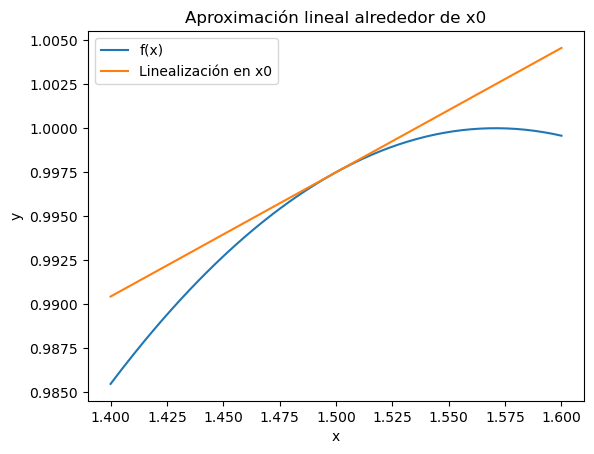

In [198]:
# Aproximación lineal en un rango
xs = torch.linspace(x0.item()-0.1, x0.item()+0.1, 200)
ys = torch.sin(xs)
lin = y0.detach().item() + fprime_autograd*(xs - x0.item())

plt.figure()
plt.plot(xs.numpy(), ys.numpy(), label='f(x)')
plt.plot(xs.numpy(), lin.numpy(), label='Linealización en x0')
plt.legend()
plt.title('Aproximación lineal alrededor de x0')
plt.xlabel('x'); plt.ylabel('y');
plt.show()

## 2. Propiedades básicas: linealidad, producto y cadena
Sea $f,g:\mathbb{R}\to\mathbb{R}$ y $a,b\in\mathbb{R}$. Verificamos:

**Linealidad**: $(af+bg)'=a f'+b g'$.

In [199]:
x = torch.tensor(0.7, requires_grad=True)
f, g = torch.sin, torch.cos
a, b = 2.0, -3.0

# LHS
y = a*f(x) + b*g(x)
x.grad = None
y.backward()
lhs = x.grad.item()

# RHS = grad de cada término por separado (se recomputa el forward cada vez)
x.grad = None
(a*f(x)).backward()
part1 = x.grad.item()

x.grad = None
(b*g(x)).backward()
part2 = x.grad.item()

rhs = part1 + part2
print({'linealidad LHS': lhs, 'RHS': rhs})


{'linealidad LHS': 3.4623374938964844, 'RHS': 3.462337374687195}


**Producto**: $(fg)'=f'g+fg'$.

In [200]:
# Producto
x = torch.tensor(0.7, requires_grad=True)
f, g = torch.sin, torch.cos

# LHS (autograd)
y = f(x) * g(x)
x.grad = None
y.backward()
LHS = x.grad.item()

# RHS = grad de cada término por separado (se recomputa el forward cada vez)
x.grad = None
f(x).backward()
fp = x.grad.item()

x.grad = None
g(x).backward()
gp = x.grad.item()

# RHS (regla del producto)
with torch.no_grad():
    RHS = (fp*g(x) + f(x)*gp).item()

print({'producto LHS': LHS, 'RHS': RHS})

{'producto LHS': 0.1699671745300293, 'RHS': 0.1699671745300293}


**Cadena**: $(f\circ g)'(x)=f'(g(x))\,g'(x)$.

In [201]:
# Cadena: f(u)=exp(u), g(x)=x^2 -> (f∘g)' = exp(x^2)*2x
x = torch.tensor(1.2, requires_grad=True)
f = torch.exp
g = (lambda z: z**2)

# Forward
y = f(g(x))

# Backward = Derivar
x.grad = None
y.backward()
LHS = x.grad.item()

with torch.no_grad():
    RHS = math.exp(x.item()**2)*2*x.item()

print({'cadena LHS': LHS, 'RHS': RHS})

{'cadena LHS': 10.129671096801758, 'RHS': 10.129671522557512}


## 3. Derivadas parciales y gradiente
Sea $f:\mathbb{R}^d\to\mathbb{R}$. Calculamos $\nabla f(x)$ con `autograd` y lo comparamos con una aproximación por diferencias finitas.

In [202]:
# Usando AutoGrad
def grad_autograd(f, x):
    x = x.clone().detach().requires_grad_(True)
    y = f(x)
    y.backward()
    return x.grad

In [203]:
# Diferenciación numérica
def grad_finite_diff(f_np, x, h=1e-4):
    g = np.zeros_like(x)
    for i in range(len(x)):
        ei = np.zeros_like(x); ei[i]=1
        g[i] = (f_np(x+h*ei)-f_np(x-h*ei))/(2*h)
    return g

In [204]:
# f(x,y)=2x^2+2xy+y^2 (forma cuadrática)
def f_vec(t):
    x,y = t[0], t[1]
    return 2*x**2 + 2*x*y + y**2

In [205]:
x0 = torch.tensor([3.0,2.0])
g_auto = grad_autograd(f_vec, x0)
g_fd = grad_finite_diff(lambda v: 2*v[0]**2 + 2*v[0]*v[1] + v[1]**2, x0.numpy())
print({'grad autograd': g_auto.tolist(), 'grad finitas': g_fd.tolist()})

{'grad autograd': [16.0, 10.0], 'grad finitas': [15.98358154296875, 9.9945068359375]}


### Aproximación lineal multivariable
Para $x\approx x_0$: $f(x)\approx f(x_0)+\langle\nabla f(x_0), x-x_0\rangle$. Verificamos el error.

In [206]:
# Punto de expansión y gradiente
x0 = torch.tensor([3.0, 2.0])
g0 = grad_autograd(f_vec, x0)
f0 = f_vec(x0).item()

In [207]:
# Curvas de nivel
r = 10
xs_grid = torch.linspace(x0[0]-r, x0[0]+r, 200)
ys_grid = torch.linspace(x0[1]-r, x0[1]+r, 200)
X, Y = torch.meshgrid(xs_grid, ys_grid, indexing='xy')

with torch.no_grad():
    Z_true = 2*X**2 + 2*X*Y + Y**2
    Z_lin  = f0 + g0[0]*(X - x0[0]) + g0[1]*(Y - x0[1])

levels = np.linspace(Z_true.min().item(), Z_true.max().item(), 25)

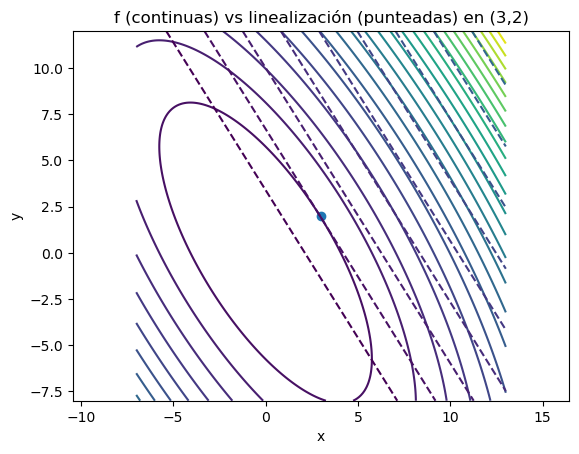

In [208]:
# f vs linealización
plt.figure()
CSa = plt.contour(X.numpy(), Y.numpy(), Z_true.numpy(), levels=levels)
CSb = plt.contour(X.numpy(), Y.numpy(), Z_lin.numpy(), levels=levels, linestyles='--')
plt.scatter([x0[0].item()], [x0[1].item()], marker='o')
plt.title('f (continuas) vs linealización (punteadas) en (3,2)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

## 4. Jacobiano $\partial f(x)$ para $f:\mathbb{R}^d\to\mathbb{R}^k$
Usamos `torch.autograd.functional.jacobian` y verificamos contra casos conocidos.

In [209]:
# Caso 1: y = W x, con W∈R^{k×d}
k, d = 4, 3
W = torch.randn(k,d)
x = torch.randn(d)
def f_lin(x):
    return W @ x

J = torch.autograd.functional.jacobian(f_lin, x)
print(f'W:\n{W}\nJ:\n{J}')

W:
tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986],
        [ 0.4033,  0.8380, -0.7193],
        [-0.4033, -0.5966,  0.1820]])
J:
tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986],
        [ 0.4033,  0.8380, -0.7193],
        [-0.4033, -0.5966,  0.1820]])


### Jacobiano respecto de $W$ en $y=Wx$
Vemos $f(W)=Wx$ con $x$ fijo. `autograd` permite jacobianos respecto de tensores de parámetros.

In [210]:
k, d = 3, 2
x = torch.randn(d)
W = torch.randn(k,d, requires_grad=True)

def f_W(W):
    return W @ x  # R^k

J_W = torch.autograd.functional.jacobian(f_W, W)  # shape (k,k,d)

# Reorganizamos J_W a (k, k*d) y comparamos con la forma teórica por bloques [x^T, 0, ...]
J_W_flat = J_W.reshape(k, -1)
theory = torch.zeros_like(J_W_flat)
for i in range(k):
    theory[i, i*d:(i+1)*d] = x
print(f'J_W:\n{J_W_flat}\ntheory:\n{theory}')

J_W:
tensor([[ 0.1227, -0.5663,  0.0000, -0.0000,  0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.1227, -0.5663,  0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000, -0.0000,  0.1227, -0.5663]])
theory:
tensor([[ 0.1227, -0.5663,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.1227, -0.5663,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.1227, -0.5663]])


## 5. Ejercicio

Calcule el gradiente de $f(x)=\tfrac12\,x^\top A x + b^\top x$.

In [211]:
import torch

# Defino A, b y x
A = torch.tensor([[2.0, 1.0],
                [1.0, 3.0]], requires_grad=False)

b = torch.tensor([1.0, -1.0], requires_grad=False)

x = torch.tensor([1.0, 3.0], requires_grad=True)

# Definición de la función f(x)
f = 0.5 * torch.dot(x, torch.matmul(A, x)) + torch.dot(b, x)

# Backward para calcular gradiente
f.backward()

print("Gradiente calculado con autograd:", x.grad)

# ∇f(x) = Ax + b
gradiente_teorico = torch.matmul(A, x) + b
print("Gradiente analítico:", gradiente_teorico)


Gradiente calculado con autograd: tensor([6., 9.])
Gradiente analítico: tensor([6., 9.], grad_fn=<AddBackward0>)
